# GCM-RCM emulator training

This notebook trains a MF BTM using the GCM-RCM data pairs described on the paper. The data is included on the repo, but to download e.g. another date for the ensembles, edit and run `../scripts/get_gcm_rcm.py`.

In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

# Packages for working with array data and tensors
import numpy as np
import torch

In [2]:
# after the imports set a seed for reproducibility
# anyhow, the results will be different on different machines
# cf. https://pytorch.org/docs/stable/notes/randomness.html
np.random.seed(0)
torch.manual_seed(0)

In [3]:
locs_gcm = np.load("../tests/data/locs_gcm.npy")
locs_rcm = np.load("../tests/data/locs_rcm.npy")

obs_gcm = np.load("../tests/data/obs_gcm.npy")
obs_rcm = np.load("../tests/data/obs_rcm.npy")

locs_gcm.shape, locs_rcm.shape, obs_gcm.shape, obs_rcm.shape

((336, 2), (78400, 2), (50, 336), (50, 78400))

In [4]:
import numpy as np

# Weird behavior if lat/lon are not in expected order
def force_latlon_first(locs):
    """
    Return a copy shaped (N, 2), column-0 = latitude, column-1 = longitude.
    Accepts input in any of these shapes/orientations:
        (N, 2)  → either [lat, lon] or [lon, lat]
        (2, N)  → either [[lat...],[lon...]] or [[lon...],[lat...]]
    Uses value ranges to detect & correct 'lon-lat' layouts.
    """
    locs = np.asarray(locs)

    # --- 1. Ensure shape (N, 2) -------------------------------------------
    if locs.shape[1] == 2:                  # already (N, 2)
        out = locs.copy()
    elif locs.shape[0] == 2:                # transpose from (2, N)
        out = locs.T.copy()
    else:
        raise ValueError("locs must be (N,2) or (2,N)")

    # --- 2. Put latitude in column-0, longitude in column-1 ---------------
    lat, lon = out[:, 0], out[:, 1]

    # Latitude must live in ±90°; longitude often exceeds that.
    if (np.abs(lat) > 90).any() and (np.abs(lon) <= 90).all():
        out = out[:, ::-1]                  # swap columns

    return out

locs_gcm = force_latlon_first(locs_gcm)
locs_rcm = force_latlon_first(locs_rcm)

In [5]:
locs_gcm.shape, locs_rcm.shape

((336, 2), (78400, 2))

In [6]:
N = 15 # Ensemble size, 
# increase for better accuracy but training will
# take more time and memory
# We use fixed indices for reproducibility
# random.sample(range(50), 10) was used to generate them
test_idx = [44, 33, 27, 1, 10, 18, 12, 29, 37, 47]
train_idx = list(set(range(50)) - set(test_idx))

In [7]:
# Split, standardize

obs_gcm_train = torch.Tensor(obs_gcm[train_idx[0:N], :])
obs_rcm_train = torch.Tensor(obs_rcm[train_idx[0:N], :])

obs_gcm_test = torch.Tensor(obs_gcm[test_idx, :])
obs_rcm_test = torch.Tensor(obs_rcm[test_idx, :])

mean_gcm = obs_gcm_train.mean(dim=0, keepdim = True)
sd_gcm = obs_gcm_train.std(dim=0, keepdim= True)
mean_rcm = obs_rcm_train.mean(dim=0, keepdim=True)
sd_rcm = obs_rcm_train.std(dim = 0, keepdim=True)
train_gcm = (obs_gcm_train - mean_gcm)/sd_gcm
train_rcm = (obs_rcm_train - mean_rcm)/sd_rcm
test_gcm = (obs_gcm_test - mean_gcm)/sd_gcm
test_rcm = (obs_rcm_test - mean_rcm)/sd_rcm
train = torch.hstack((train_gcm, train_rcm))
test = torch.hstack((test_gcm, test_rcm))

In [8]:
from scipy.spatial import ConvexHull
import numpy as np

# RCM hull for visualization
lat_rcm = locs_rcm[:, 0]
lon_rcm = locs_rcm[:, 1]
pts = np.column_stack([lon_rcm, lat_rcm])
hull = ConvexHull(pts)
order = np.r_[hull.vertices, hull.vertices[0]]
hull_lon, hull_lat = pts[order, 0], pts[order, 1]

def overlay_hull_on_heatmap(ax, grid, hull_lon, hull_lat, **plot_kw):
    """
    grid: DataFrame from pivot(index='lat', columns='lon', values='z')
    Maps lon/lat to heatmap's column/row indices and plots the polygon.
    """
    # ensure consistent, increasing axes for mapping
    grid = grid.sort_index().sort_index(axis=1)
    lon_bins = grid.columns.to_numpy()
    lat_bins = grid.index.to_numpy()

    # map hull lon/lat → heatmap indices (0..n-1)
    x_idx = np.interp(hull_lon, lon_bins, np.arange(len(lon_bins)))
    y_idx = np.interp(hull_lat, lat_bins, np.arange(len(lat_bins)))

    ax.plot(x_idx, y_idx, **({"ls": "--", "lw": 0.8, "color": "k"} | plot_kw))

# Figure 1

We plot two training ensemble members. The figure on the paper has two different ensemble members, but on this notebook I did not use the full training ensemble so I picked some others.

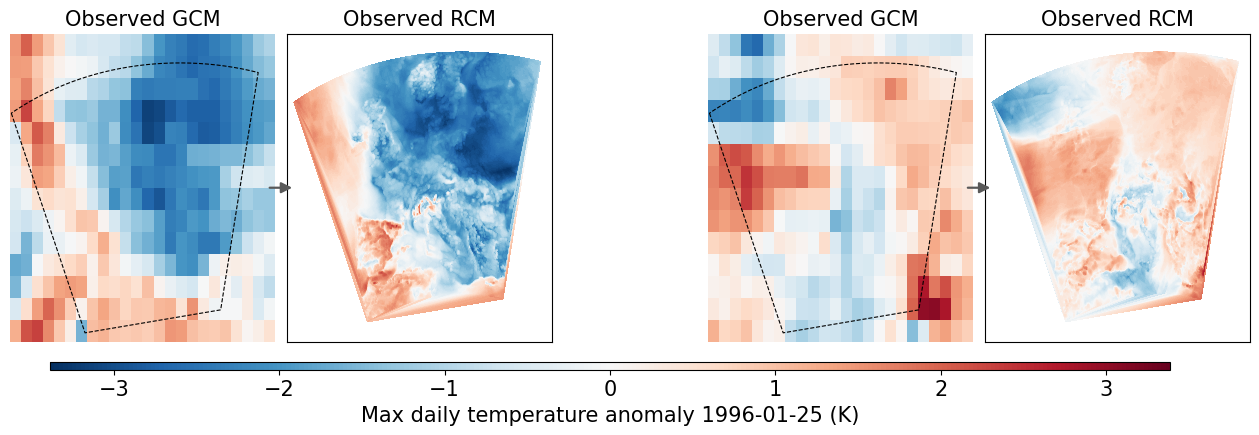

In [9]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.tri import Triangulation
from matplotlib.patches import ConnectionPatch
import seaborn as sns

# Shared color scale
vmin = train.min().item()
vmax = train.max().item()
absmax = max(abs(vmin), abs(vmax))
vmin, vmax = -absmax, absmax

mpl.rcParams.update({
    "font.size": 10*1.5,
    "axes.titlesize": 10*1.5,
    "axes.labelsize": 10*1.5,
    "xtick.labelsize": 10*1.5,
    "ytick.labelsize": 10*1.5,
    "legend.fontsize": 10*1.5,
})

# middle spaces column
fig = plt.figure(figsize=(16, 4))
gs  = fig.add_gridspec(1, 5, width_ratios=[1, 1, 0.5, 1, 1], wspace=0.05)
ax0 = fig.add_subplot(gs[0, 0])  # GCM 
ax1 = fig.add_subplot(gs[0, 1])  # RCM 
axS = fig.add_subplot(gs[0, 2])  # spacer
ax2 = fig.add_subplot(gs[0, 3])  # GCM 
ax3 = fig.add_subplot(gs[0, 4])  # RCM

axS.axis("off")  # hide spacer panel

axs = [ax0, ax1, ax2, ax3]

# Build the first GCM grid and extract grid centers
lat_gcm = locs_gcm[:, 0]
lon_gcm = locs_gcm[:, 1]

gcm_df0 = pd.DataFrame({'lat': lat_gcm, 'lon': lon_gcm, 'z': train[0][:336]})
gcm_grid0 = gcm_df0.pivot(index='lat', columns='lon', values='z')
gcm_grid0 = gcm_grid0.sort_index().sort_index(axis=1)  # ensure increasing order
lon_centers = gcm_grid0.columns.to_numpy()
lat_centers = gcm_grid0.index.to_numpy()
nlon = len(lon_centers); nlat = len(lat_centers)

def to_heatmap_idx(lon, lat, lon_centers, lat_centers):
    x_idx = np.interp(lon, lon_centers, np.arange(nlon))
    y_idx = np.interp(lat, lat_centers, np.arange(nlat))
    return x_idx, y_idx

# RCM triangulation IN INDEX SPACE (manage whitespace)
x_idx_rcm, y_idx_rcm = to_heatmap_idx(lon_rcm, lat_rcm, lon_centers, lat_centers)
triang_idx = Triangulation(x_idx_rcm, y_idx_rcm)

# Heatmap extent (half-cell padding) in index coords
XMIN, XMAX = -0.5, nlon - 0.5
YMIN, YMAX = -0.5, nlat - 0.5

# Panel 1: GCM ensemble member
sns.heatmap(gcm_grid0, cmap="RdBu_r", ax=ax0,
            vmin=vmin, vmax=vmax, cbar=False, xticklabels=False, yticklabels=False)
ax0.invert_yaxis()
ax0.set_title("Observed GCM"); ax0.set_xlabel(""); ax0.set_ylabel("")
overlay_hull_on_heatmap(ax0, gcm_grid0, hull_lon, hull_lat)

# Panel 2: RCM ensemble member
z_rcm_38 = train[0][336:]
ax1.tricontourf(triang_idx, z_rcm_38, levels=100, cmap="RdBu_r", vmin=vmin, vmax=vmax)
ax1.set_xlim(XMIN, XMAX); ax1.set_ylim(YMIN, YMAX)
ax1.set_aspect('auto')
ax1.set_xticks([]); ax1.set_yticks([])
ax1.set_title("Observed RCM"); ax1.set_xlabel(""); ax1.set_ylabel("")

# Panel 3: GCM ensemble member
gcm_df1 = pd.DataFrame({'lat': lat_gcm, 'lon': lon_gcm, 'z': train[1][:336]})
gcm_grid1 = (gcm_df1.pivot(index='lat', columns='lon', values='z')
                      .reindex(index=lat_centers, columns=lon_centers))
sns.heatmap(gcm_grid1, cmap="RdBu_r", ax=ax2,
            vmin=vmin, vmax=vmax, cbar=False, xticklabels=False, yticklabels=False)
ax2.invert_yaxis()
ax2.set_title("Observed GCM"); ax2.set_xlabel(""); ax2.set_ylabel("")
overlay_hull_on_heatmap(ax2, gcm_grid1, hull_lon, hull_lat)

# Panel 4: RCM ensemble member
z_rcm_39 = train[1][336:]
ax3.tricontourf(triang_idx, z_rcm_39, levels=100, cmap="RdBu_r", vmin=vmin, vmax=vmax)
ax3.set_xlim(XMIN, XMAX); ax3.set_ylim(YMIN, YMAX)
ax3.set_aspect('auto')
ax3.set_xticks([]); ax3.set_yticks([])
ax3.set_title("Observed RCM"); ax3.set_xlabel(""); ax3.set_ylabel("")

# Grey connecting lines between pairs: [0]→[1] and [2]→[3]
# indicating conditioning relationship

def connect_arrow(ax_from, ax_to, y=0.50, color='0.5', lw=1.6, ms=16, rad=0.0):
    """
    Draw a grey arrow from the right edge of ax_from to the left edge of ax_to
    at a normalized vertical position y (0..1). Set rad>0 for a gentle curve.
    """
    con = ConnectionPatch(
        (0.98, y), (0.02, y),
        coordsA=ax_from.transAxes, coordsB=ax_to.transAxes,
        arrowstyle="-|>", mutation_scale=ms,
        lw=lw, color=color,
        connectionstyle=f"arc3,rad={rad}",
        shrinkA=0, shrinkB=0, clip_on=False
    )
    con.set_zorder(10)
    ax_from.figure.add_artist(con)

# Replace your previous connect() calls with:
connect_arrow(ax0, ax1, y=0.50, color = '0.35')          # pair 1
connect_arrow(ax2, ax3, y=0.50, color = '0.35')          # pair 2

# -----------------------------
# Shared horizontal colour-bar
# -----------------------------
cax = fig.add_axes([0.15, 0.04, 0.70, 0.02])
sm  = plt.cm.ScalarMappable(cmap="RdBu_r", norm=plt.Normalize(vmin=vmin, vmax=vmax))
cbar = fig.colorbar(sm, cax=cax, orientation='horizontal')
cbar.set_label("Max daily temperature anomaly 1996-01-25 (K)")

plt.show()
# uncomment to save as PDF 
#fig.savefig("climate_anomalies.pdf", dpi=150, bbox_inches="tight",
#            metadata={"Creator": "", "Producer": ""})


Order acording to the conditional maximin order and find the multifidelity previously ordered nearest neighbors.

In [10]:
from veccs.orderings import maxmin_pred_cpp, find_nns_l2_mf

# Stack all locations
locs = torch.vstack((torch.Tensor(locs_gcm), torch.Tensor(locs_rcm)))

# Maximin ordering of the locations using veccs
ord = maxmin_pred_cpp(locs_gcm, locs_rcm)

ord_gcm = ord[:336]
ord_rcm = ord[336:]

locs_ord = locs[ord, ...]
obs_ord = train[..., ord]
obs_test_ord = test[..., ord]
obs_ord_gcm = train_gcm[..., ord_gcm]
# indexes from 0 for easier indexing
obs_ord_hf = train_rcm[..., ord_rcm - 336]

# Finding nearest neighbors using the `veccs` package.
# For this example let's use 20 max nearest neighbors. 
# For the multifidelity version, pass a list of the ordered locs from
# lowest to highest fidelity
locs_all = [locs_ord[:336].detach().numpy(), locs_ord[336:].detach().numpy()]
largest_conditioning_set = 50
nn = find_nns_l2_mf(locs_all, largest_conditioning_set)

Let's compute $\ell_{i}$ and plot it wrt to $i$. Should be decreasing, but for multifidelity scenarios we can get a slight bump on the first indices of a new fidelity, when lower fidelity points are closer than the first few higher fidelity points to the lower fidelity.

In [11]:
from batram.data import MultiFidelityData, AugmentDataMF

fidelity_sizes = torch.as_tensor(list(map(len, locs_all)))
data = MultiFidelityData.new(locs_ord, obs_ord, torch.as_tensor(nn), fidelity_sizes)
data_augmented = AugmentDataMF()
aug_data = data_augmented(data)
scales = aug_data.scales
min(scales)

tensor(5.6245e-05)

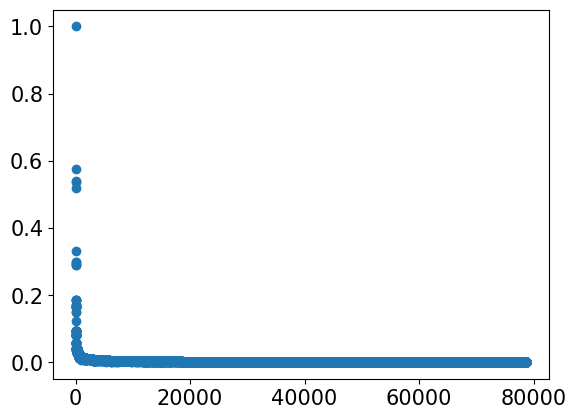

In [12]:
x = range(1, 78737)
plt.scatter(x, scales)

In [13]:
# Initialize hyperparameters, we have found empirically
# that this is a reasonable initialization.
R = 2  # Number of fidelities
theta_init = torch.zeros((9*R-2))
log_2m = data.response[:, 0].square().mean().log()
# Nugget 1
theta_init[:R] = log_2m 
# Nugget 2
theta_init[R:2*R] = 0.2
# Sigma 1
theta_init[2*R:3*R] = 0.0
# Sigma 2
theta_init[3*R:4*R] = 0.0
# Theta q 0 within
theta_init[4*R:5*R] = 0.0
# Theta q 1 within
theta_init[5*R:6*R] = 0.0
# Theta q 0 between
theta_init[6*R:7*R-1] = 0.0
# Theta q 1 between
theta_init[7*R-1:8*R-2] = 0.0
# Theta gammas
theta_init[8*R-2:9*R-2] = -1.0

In [14]:
from batram.mf import MultiFidelityTM

# nug_mult = 4 as in the paper
tm = MultiFidelityTM(data, theta_init, nug_mult = 4.0)
# The `nsteps` argument is always required. When using a user-defined optimizer
# we ignore the initial learning rate. The `batch_size` specifies how to perform
# minibatch gradient descent. The `test_data` argument is optional and is used
# to compute the test loss at each step.
nsteps = 200
opt = torch.optim.Adam(tm.parameters(), lr=0.01, weight_decay=1e-4)
sched = torch.optim.lr_scheduler.CosineAnnealingLR(opt, nsteps, eta_min = 0.001)
res = tm.fit(
    nsteps, 0.01
)

c:\Users\Aleja\anaconda3\envs\batram-mf\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Train Loss: -2298466.750: 100%|██████████| 200/200 [14:31<00:00,  4.36s/it]


# Losses

Here we plot the losses. Note that the `losses` vector contains the losses of the $R$ 

Text(0, 0.5, 'Loss')

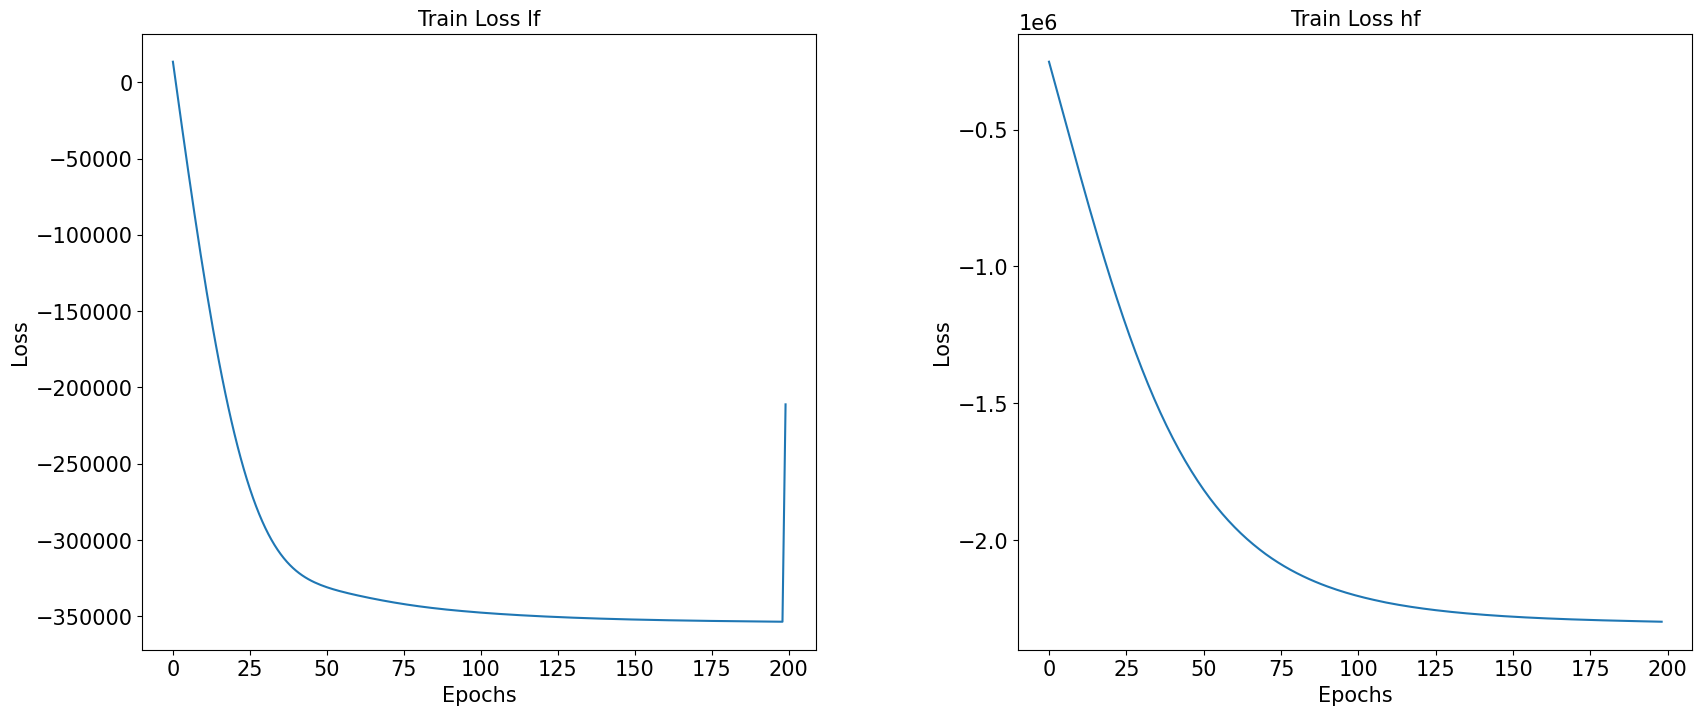

In [15]:
gspec = {"wspace": 0.3, "hspace": 0.1}
fig, ax = plt.subplots(1, 2, figsize=(20, 8), gridspec_kw=gspec)#, squeeze=True)
ax[0].plot(res.losses[1:nsteps+1])
ax[0].set_title('Train Loss lf')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')

ax[1].plot(res.losses[201:602])
ax[1].set_title('Train Loss hf')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')

Text(0.5, 1.0, 'High fidelity parameters')

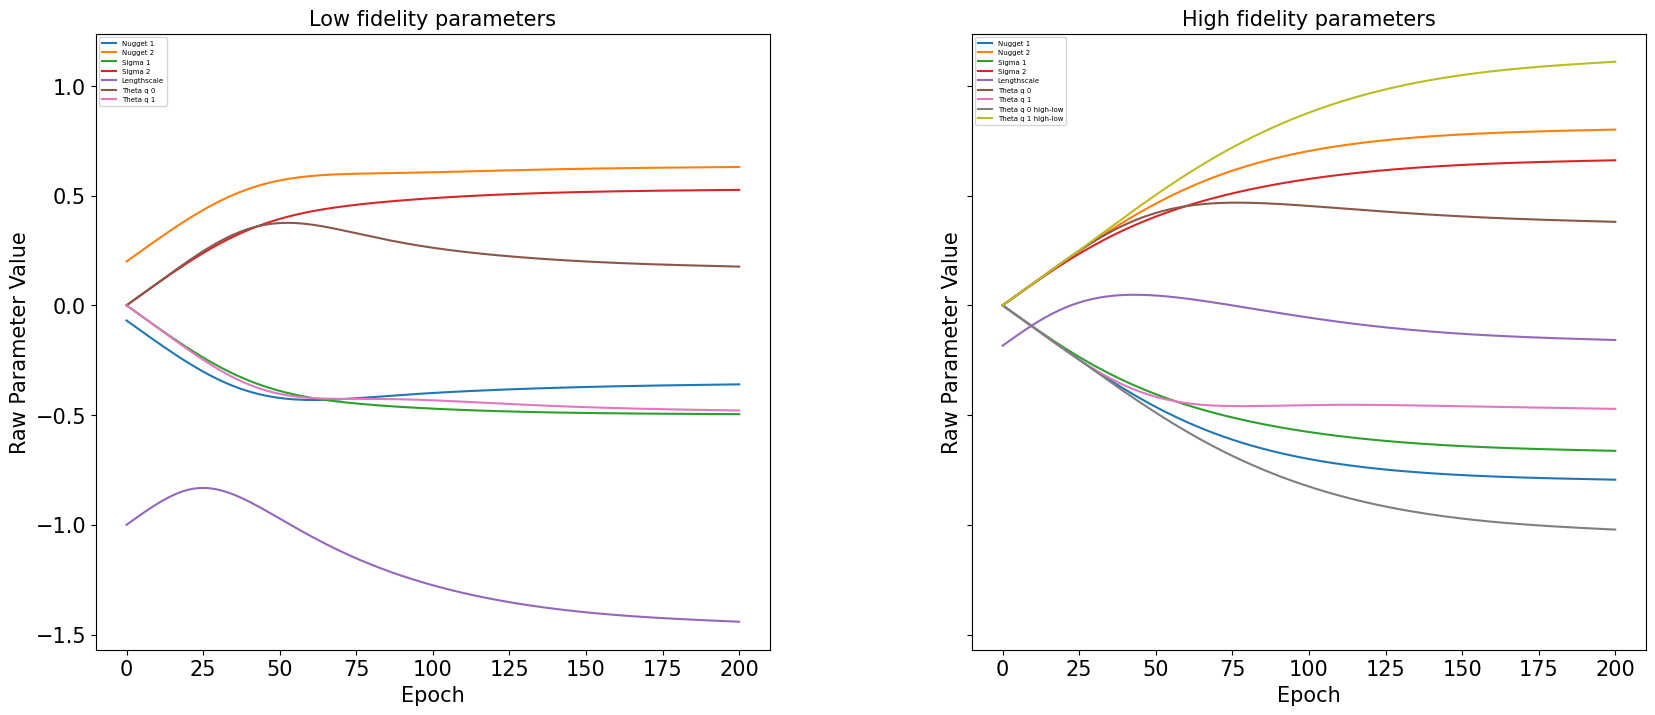

In [16]:
gspec = {"wspace": 0.3, "hspace": 0.1}
fig, ax = plt.subplots(1, 2, figsize=(20, 8), gridspec_kw=gspec, sharey=True)
labels=["Nugget 1", "Nugget 2", "Sigma 1", "Sigma 2", "Lengthscale", "Theta q 0", 
        "Theta q 1"]
to_plot = [res.param_chain["nugget.nugget_params"][:nsteps+1,0], res.param_chain["nugget.nugget_params"][:nsteps+1,2],
           res.param_chain["kernel.sigma_params"][:nsteps+1,0], res.param_chain["kernel.sigma_params"][:nsteps+1,2],
           res.param_chain["kernel.lengthscale"][:nsteps+1,0], res.param_chain["kernel.theta_q"][:nsteps+1,0], 
           res.param_chain["kernel.theta_q"][:nsteps+1,2]]
param_chain = np.vstack(to_plot).transpose()
ax[0].plot(param_chain, label = labels)
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Raw Parameter Value")
ax[0].legend(loc=2, prop={'size': 5})
ax[0].set_title('Low fidelity parameters')

labels=["Nugget 1", "Nugget 2", "Sigma 1", "Sigma 2", "Lengthscale", "Theta q 0", 
        "Theta q 1", "Theta q 0 high-low", "Theta q 1 high-low"]
to_plot = [res.param_chain["nugget.nugget_params"][nsteps+1:2*nsteps+2,1], res.param_chain["nugget.nugget_params"][nsteps+1:2*nsteps+2,3],
           res.param_chain["kernel.sigma_params"][nsteps+1:2*nsteps+2,1], res.param_chain["kernel.sigma_params"][nsteps+1:2*nsteps+2,3],
           res.param_chain["kernel.lengthscale"][nsteps+1:2*nsteps+2,1], res.param_chain["kernel.theta_q"][nsteps+1:2*nsteps+2,1], 
           res.param_chain["kernel.theta_q"][nsteps+1:2*nsteps+2, 3], res.param_chain["kernel.theta_q"][nsteps+1:2*nsteps+2, 4],
           res.param_chain["kernel.theta_q"][nsteps+1:2*nsteps+2, 5]]
param_chain = np.vstack(to_plot).transpose()
ax[1].plot(param_chain, label = labels)
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Raw Parameter Value")
ax[1].legend(loc=2, prop={'size': 5})
ax[1].set_title('High fidelity parameters')

# Nearest Neighbors

First the raw parameters, $\theta_{q,0}$ and $\theta_{q,1}$ for each fidelity and between fidelities. We have scaling

$$ exp(\theta_{q,0}^{(r,r)} - \theta_{q,1}^{(r,r)}k) $$

with $k$ is the number of neighbors. For finding neighbors on the previous fidelity

$$ exp(\theta_{q,0}^{(r,r-1)} - \theta_{q,1}^{(r,r-1)}k) $$


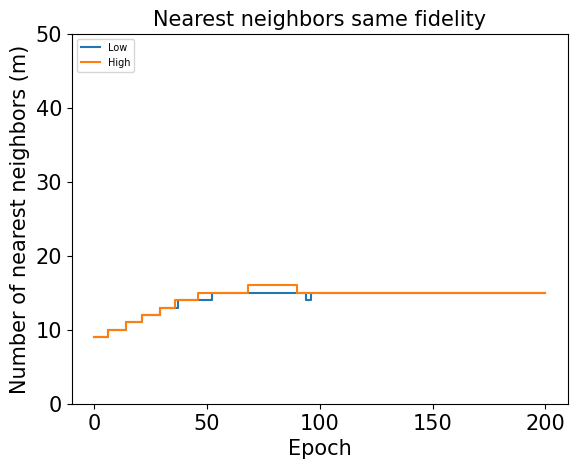

In [17]:
def det_m(max_m, theta_q_0, theta_q_1): 
    rng = torch.arange(max_m) + 1
    scales = scale(theta_q_0, theta_q_1, rng)
    mask = scales >= 0.01
    m = mask.sum()
    return m

def scale(theta_q_0, theta_q_1, k):
    theta_q_1 = torch.exp(theta_q_1)
    return torch.exp(theta_q_0 - 0.5*theta_q_1*k)

ms = []
theta_q_00 = res.param_chain["kernel.theta_q"][:nsteps+1,0] 
theta_q_10 = res.param_chain["kernel.theta_q"][:nsteps+1,2]
theta_q_01 = res.param_chain["kernel.theta_q"][nsteps+1:2*nsteps+2,1]
theta_q_11 = res.param_chain["kernel.theta_q"][nsteps+1:2*nsteps+2,3]
thetas_q_0 = [theta_q_00, theta_q_01]
thetas_q_1 = [theta_q_10, theta_q_11]
for i in range(R):
    m = []
    theta_q_0 = thetas_q_0[i]
    theta_q_1 = thetas_q_1[i]
    for j in range(len(theta_q_0)):
        tq0 = torch.tensor(theta_q_0[j])
        tq1 = torch.tensor(theta_q_1[j])
        m1 = det_m(50, tq0, tq1)
        m.append(m1)
    ms.append(m)

_, ax = plt.subplots(1, 1)
epochs = np.arange(len(ms[0]))
labels = ['Low', 'High']
for m, label in zip(ms, labels):
    ax.step(epochs, m, label=label)
ax.set_title("Nearest neighbors same fidelity")
ax.set_xlabel("Epoch")
ax.set_ylabel("Number of nearest neighbors (m)")
ax.set_ylim(0, data.max_m)
ax.legend(loc=2, prop={'size': 7})

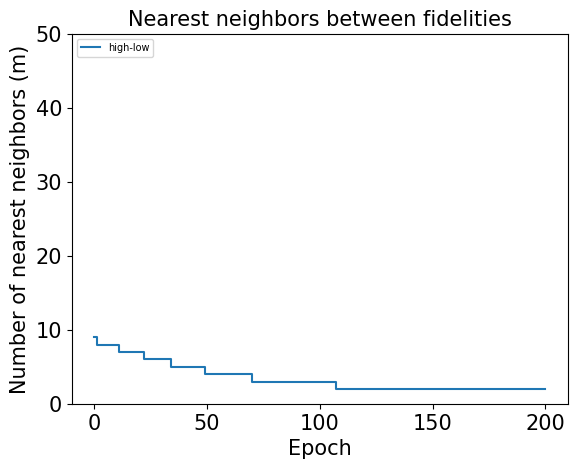

In [18]:
theta_q_0 = res.param_chain["kernel.theta_q"][nsteps+1:2*nsteps+2, 4]
theta_q_1 = res.param_chain["kernel.theta_q"][nsteps+1:2*nsteps+2, 5]
m = []
for j in range(len(theta_q_0)):
    tq0 = torch.tensor(theta_q_0[j])
    tq1 = torch.tensor(theta_q_1[j])
    m2 = det_m(50, tq0, tq1)
    m.append(m2)

_, ax = plt.subplots(1, 1)
epochs = np.arange(len(ms[0]))
label = ['high-low']
ax.step(epochs, m, label=label)
ax.set_title("Nearest neighbors between fidelities")
ax.set_xlabel("Epoch")
ax.set_ylabel("Number of nearest neighbors (m)")
ax.set_ylim(0, data.max_m)
ax.legend(loc=2, prop={'size': 7})

In [19]:
ord_lf = ord[:336]
ord_hf = ord[336:]

obs = obs_test_ord[0].to(torch.float64)
true_lf = obs[:336] # 0, 0
true_hf = obs[336:] # 0, 1

cond_sample1 = tm.cond_sample(true_lf, res, 1)[0, 336:] # 1, 1
cond_sample2 = tm.cond_sample(true_lf, res, 1)[0, 336:] # 1, 2

sample_full = tm.cond_sample(obs, res, 0)
pseudo_lf = sample_full[0, :336] # 2, 0
sample_cond_hf1 = tm.cond_sample(pseudo_lf, res, 1)[0, 336:] # 2, 1
sample_cond_hf2 = tm.cond_sample(pseudo_lf, res, 1)[0, 336:] # 2, 2

In [20]:
from scipy.spatial import ConvexHull
import numpy as np

# --- compute RCM convex hull once (lon/lat order) ---
pts = np.column_stack([lon_rcm, lat_rcm])
hull = ConvexHull(pts)
order = np.r_[hull.vertices, hull.vertices[0]]
hull_lon, hull_lat = pts[order, 0], pts[order, 1]

def overlay_hull_on_heatmap(ax, grid, hull_lon, hull_lat, **plot_kw):
    """
    grid: DataFrame from pivot(index='lat', columns='lon', values='z')
    Maps lon/lat to heatmap's column/row indices and plots the polygon.
    """
    # ensure consistent, increasing axes for mapping
    grid = grid.sort_index().sort_index(axis=1)
    lon_bins = grid.columns.to_numpy()
    lat_bins = grid.index.to_numpy()

    # map hull lon/lat → heatmap indices (0..n-1)
    x_idx = np.interp(hull_lon, lon_bins, np.arange(len(lon_bins)))
    y_idx = np.interp(hull_lat, lat_bins, np.arange(len(lat_bins)))

    ax.plot(x_idx, y_idx, **({"ls": "--", "lw": 0.8, "color": "k"} | plot_kw))

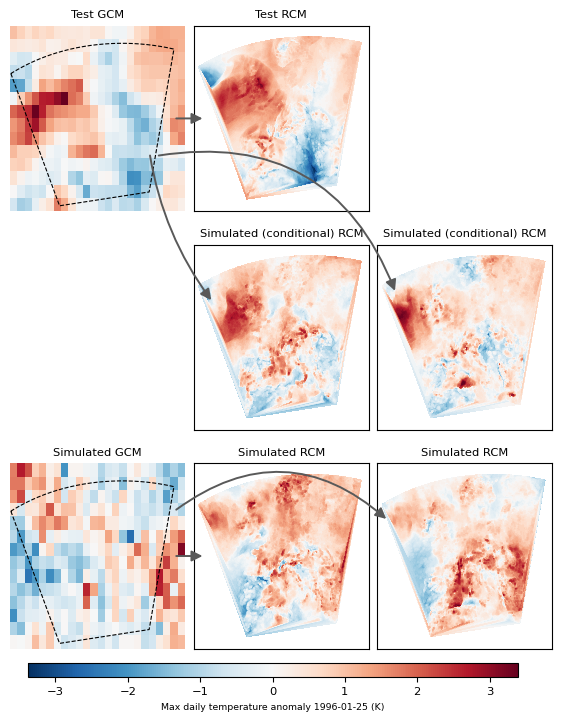

In [21]:
import numpy as np
from matplotlib.tri import Triangulation
from matplotlib.patches import ConnectionPatch

# -------------------------------
# Shared colour scale (yours)
# -------------------------------
vmin = train.min().item()
vmax = train.max().item()
absmax = max(abs(vmin), abs(vmax))
vmin, vmax = -absmax, absmax

import matplotlib as mpl
import matplotlib.pyplot as plt

# ------------------------------------------
# 1) Global style (yours)
# ------------------------------------------
mpl.rcParams.update({
    "font.size": 6*1.5,
    "axes.titlesize": 5.5*1.5,
    "axes.labelsize": 4.5*1.5,
    "xtick.labelsize": 5.5*1.5,
    "ytick.labelsize": 5.5*1.5,
    "legend.fontsize": 5.5*1.5,
})

# ------------------------------------------
# 2) Figure layout (yours)
# ------------------------------------------
fig, axs = plt.subplots(3, 3, figsize=(7, 7), constrained_layout=False)
plt.subplots_adjust(wspace=0.05, hspace=0.18, bottom=0.08, top=0.97)

# ------------------------------------------
# Build first GCM heatmap and extract edges
# ------------------------------------------
gcm_df = pd.DataFrame({'lat': lat_gcm, 'lon': lon_gcm, 'z': true_lf[ord_lf.argsort()]})
gcm_grid = gcm_df.pivot(index='lat', columns='lon', values='z').sort_index().sort_index(axis=1)

sns.heatmap(gcm_grid, cmap="RdBu_r", ax=axs[0, 0],
            vmin=vmin, vmax=vmax, cbar=False, xticklabels=False, yticklabels=False)
axs[0, 0].invert_yaxis()
axs[0, 0].set_title("Test GCM"); axs[0, 0].set_xlabel(""); axs[0, 0].set_ylabel("")
overlay_hull_on_heatmap(axs[0, 0], gcm_grid, hull_lon, hull_lat)

# Compute exact heatmap edges (includes half-cell padding)
lon_centers = gcm_grid.columns.to_numpy()
lat_centers = gcm_grid.index.to_numpy()

def edges_from_centers(c):
    c = np.asarray(c)
    step_left, step_right = c[1]-c[0], c[-1]-c[-2]
    mids = (c[:-1] + c[1:]) / 2
    return np.concatenate(([c[0] - step_left/2], mids, [c[-1] + step_right/2]))

lon_edges = edges_from_centers(lon_centers)
lat_edges = edges_from_centers(lat_centers)
LON_MIN, LON_MAX = lon_edges[0], lon_edges[-1]
LAT_MIN, LAT_MAX = lat_edges[0], lat_edges[-1]

# Helper to apply GCM extent to any RCM axis (keeps panel size the same)
def apply_gcm_extent(ax):
    ax.set_xlim(LON_MIN, LON_MAX)
    ax.set_ylim(LAT_MIN, LAT_MAX)
    ax.set_aspect('auto')   # keep physical panel size matching heatmaps
    ax.set_xmargin(0); ax.set_ymargin(0)

# ------------------------------------------
# RCM panels (Observed row)
# ------------------------------------------
lat_rcm = locs_rcm[:, 0]
lon_rcm = locs_rcm[:, 1]
triang = Triangulation(lon_rcm, lat_rcm)

axs[0, 1].tricontourf(triang, true_hf[ord_hf.argsort()], levels=100, cmap="RdBu_r", vmin=vmin, vmax=vmax)
apply_gcm_extent(axs[0, 1])
axs[0, 1].set_title("Test RCM")
axs[0, 1].set_xticks([]); axs[0, 1].set_yticks([]); axs[0, 1].set_xlabel(""); axs[0, 1].set_ylabel("")

axs[0, 2].axis("off")

# ------------------------------------------
# Conditioned BTM row
# ------------------------------------------
axs[1, 0].axis("off")

z_rcm = cond_sample1[ord_hf.argsort()]
axs[1, 1].tricontourf(triang, z_rcm, levels=100, cmap="RdBu_r", vmin=vmin, vmax=vmax)
apply_gcm_extent(axs[1, 1])
axs[1, 1].set_title("Simulated (conditional) RCM")
axs[1, 1].set_xticks([]); axs[1, 1].set_yticks([]); axs[1, 1].set_xlabel(""); axs[1, 1].set_ylabel("")

z_rcm = cond_sample2[ord_hf.argsort()]
axs[1, 2].tricontourf(triang, z_rcm, levels=100, cmap="RdBu_r", vmin=vmin, vmax=vmax)
apply_gcm_extent(axs[1, 2])
axs[1, 2].set_title("Simulated (conditional) RCM")
axs[1, 2].set_xticks([]); axs[1, 2].set_yticks([]); axs[1, 2].set_xlabel(""); axs[1, 2].set_ylabel("")

# ------------------------------------------
# Unconditional row
# ------------------------------------------
z_rcm = sample_cond_hf1[ord_hf.argsort()]
z_gcm = pseudo_lf[ord_lf.argsort()]
gcm_df = pd.DataFrame({'lat': lat_gcm, 'lon': lon_gcm, 'z': z_gcm})
gcm_grid = gcm_df.pivot(index='lat', columns='lon', values='z').reindex(index=lat_centers, columns=lon_centers)

sns.heatmap(gcm_grid, cmap="RdBu_r", ax=axs[2, 0],
            vmin=vmin, vmax=vmax, cbar=False, xticklabels=False, yticklabels=False)
axs[2, 0].invert_yaxis()
axs[2, 0].set_title("Simulated GCM"); axs[2, 0].set_xlabel(""); axs[2, 0].set_ylabel("")
overlay_hull_on_heatmap(axs[2, 0], gcm_grid, hull_lon, hull_lat)

axs[2, 1].tricontourf(triang, z_rcm, levels=100, cmap="RdBu_r", vmin=vmin, vmax=vmax)
apply_gcm_extent(axs[2, 1])
axs[2, 1].set_title("Simulated RCM")
axs[2, 1].set_xticks([]); axs[2, 1].set_yticks([]); axs[2, 1].set_xlabel(""); axs[2, 1].set_ylabel("")

z_rcm = sample_cond_hf2[ord_hf.argsort()]
axs[2, 2].tricontourf(triang, z_rcm, levels=100, cmap="RdBu_r", vmin=vmin, vmax=vmax)
apply_gcm_extent(axs[2, 2])
axs[2, 2].set_title("Simulated RCM")
axs[2, 2].set_xticks([]); axs[2, 2].set_yticks([]); axs[2, 2].set_xlabel(""); axs[2, 2].set_ylabel("")

# ------------------------------------------
# 3) Connecting arrows between panels
# ------------------------------------------
def connect(ax_from, ax_to, start=(0.95, 0.50), end=(0.05, 0.50),
            rad=0.0, color="0.70", lw=1.4, ms=16):
    """
    Arrow between axes in axes-fraction coords. 'rad' controls curvature.
    Positive rad bows counterclockwise, negative rad clockwise.
    """
    con = ConnectionPatch(
        start, end,
        coordsA=ax_from.transAxes, coordsB=ax_to.transAxes,
        arrowstyle="-|>", mutation_scale=ms,
        lw=lw, color=color,
        connectionstyle=f"arc3,rad={rad}",
        shrinkA=0, shrinkB=0, clip_on=False
    )
    con.set_zorder(10)
    fig.add_artist(con)


connect(axs[0,0], axs[0,1], start=(0.95, 0.50), end=(0.05, 0.50), rad=0.0, color='0.35')
connect(axs[0,0], axs[1,2], start=(0.85, 0.30), end=(0.10, 0.75), rad=-0.4, color='0.35')

# From ax[0,0] -> ax[1,1] and ax[1,2] (slight curve so arrows don’t hug borders)
connect(axs[0,0], axs[1,1], start=(0.80, 0.30), end=(0.10, 0.70), rad=0.12, color='0.35')
#connect(axs[0,0], axs[1,2], start=(0.85, 0.25), end=(0.10, 0.75), rad=0.18, color='0.65')

# From ax[2,0] -> ax[2,1] and ax[2,2] (straight right)
connect(axs[2,0], axs[2,1], start=(0.95, 0.50), end=(0.05, 0.50), rad=0.0, color='0.35')
connect(axs[2,0], axs[2,2], start=(0.95, 0.75), end=(0.05, 0.7), rad=-0.4, color='0.35')

# ------------------------------------------
# Shared horizontal colour-bar (yours)
# ------------------------------------------
cax = fig.add_axes([0.15, 0.04, 0.70, 0.02])
sm  = plt.cm.ScalarMappable(cmap="RdBu_r", norm=plt.Normalize(vmin=vmin, vmax=vmax))
cbar = fig.colorbar(sm, cax=cax, orientation='horizontal')
cbar.set_label("Max daily temperature anomaly 1996-01-25 (K)")

plt.show()
#fig.savefig("climate_anomalies_simulated.pdf", dpi=150, bbox_inches="tight",
#            metadata={"Creator": "", "Producer": ""})
